## Reproduce figures in the paper for  GAS/VVS

In [1]:
base_dir = 'results/'
dir_individual = base_dir + 'gaswvs/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ast
from collections import defaultdict

import sys
sys.path.append('..')

In [3]:
from plot_utils.models import hf_models, model_names, instruct, model_sizes, openai_models

all_models = list(set(hf_models) - {'mpt', 'mpt-chat', 'mpt-instruct'})

all_models = sorted(all_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = list(set(instruct.keys()).intersection(set(all_models)))
instruction_models = sorted(instruction_models, key=lambda x: model_sizes[x])

### Load human responses

In [4]:
nqs = 2520  # total number of questions from which we have responses
dataset = pd.read_csv('results/global_opinions.csv')['selections'][:nqs]

def convert_dict(string_representation):
    content_start = string_representation.index('{')
    content_end = string_representation.rindex('}') + 1
    content = string_representation[content_start:content_end]

    dict_ast = ast.literal_eval(content)

    return defaultdict(list, dict_ast)

def process_name(name):
    if '(' in name:
         name = name[:name.rfind('(')]
    return name.strip()

# Extract distributions for each question and country
census_responses = {i: {} for i in range(nqs)}
for i, row in enumerate(dataset):
    for c, p in convert_dict(row).items():
        census_responses[i][process_name(c)] = np.array(p)
        
countries = set.union(*[set(cv.keys()) for cv in census_responses.values()])
n_categories = {i: len(list(convert_dict(row).values())[0]) for i, row in enumerate(dataset)}
variables = list(n_categories.keys())

### Load model responses

In [5]:
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

naive_responses = load_naive_responses(dir_individual, all_models, n_categories)
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, variables)

variables = [v for v in variables if adjusted_responses[v][all_models[0]].size != 1]
choice_responses = {k: v for k, v in choice_responses.items() if k in variables}
adjusted_responses = {k: v for k, v in adjusted_responses.items() if k in variables}
print('Number of questions: ', len(variables))

Loading naive responses...


100%|██████████| 30/30 [00:02<00:00, 12.28it/s]


Loading adjusted responses...


100%|██████████| 30/30 [03:01<00:00,  6.06s/it]

Number of questions:  2496


In [6]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}

naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Figure 2a

In [7]:
variables_ = np.random.choice(variables, 100, replace=False)

(-0.5711538461538461, 0.9)

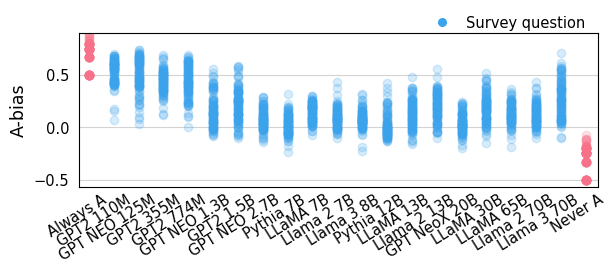

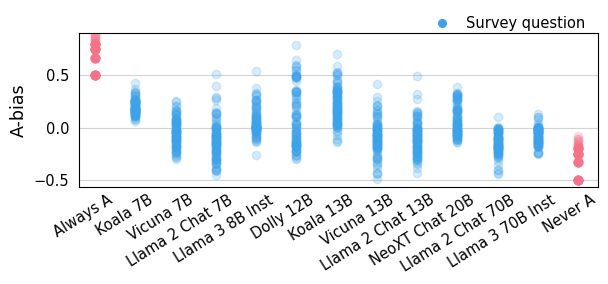

In [8]:
from plot_utils.plot_utils import plot_a_bias

a_bias = {m: [choice_responses[v][m][0] - (1. / n_categories[v]) for v in variables_] for m in all_models}
a_bias['alwaysA'] = [1. - (1. / n_categories[v]) for v in variables_]
a_bias['neverA'] = [0. - (1. / n_categories[v]) for v in variables_]
model_names_A = {'alwaysA': 'Always A', 'neverA': 'Never A', **model_names}


plot_a_bias(a_bias, ['alwaysA'] + base_models + ['neverA'], model_names_A, figsize=(6.7, 2), alpha=0.2, fontsize=10.5)
plt.ylim([None, 0.9])
plt.savefig('plots/a_bias_gas.pdf', bbox_inches='tight')

plot_a_bias(a_bias, ['alwaysA'] + instruction_models + ['neverA'], model_names_A, figsize=(6.7, 2), alpha=0.2, fontsize=10.5)
plt.savefig('plots/a_bias_instruct_gas.pdf', bbox_inches='tight')
plt.ylim([None, 0.9])

### Figure 4  and Figure 5a

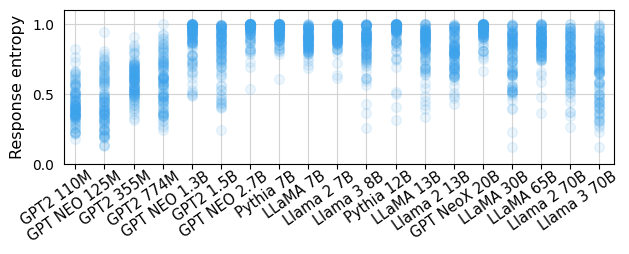

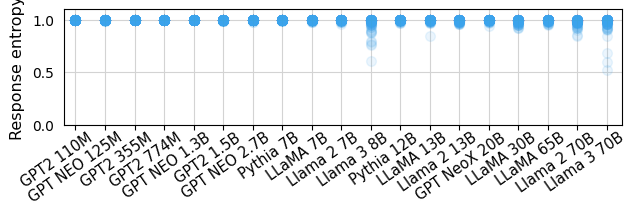

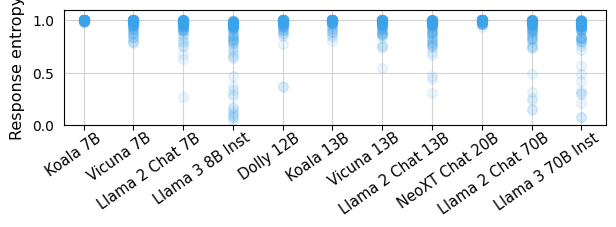

In [9]:
from plot_utils.plot_utils import plot_adjusted_entropy

plot_adjusted_entropy(naive_norm_entropies, census_entropies=None, 
                      models=base_models, variables=variables_, 
                      model_names=model_names, figsize=(7.1, 2), alpha=0.1, fontsize=10.5)
plt.savefig('plots/unadjusted_entropy_gas.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, census_entropies=None, 
                      models=base_models, variables=variables_, 
                      model_names=model_names, figsize=(7.2, 1.5), ylegend=1.3, alpha=0.1, fontsize=10.5)
plt.savefig('plots/adjusted_entropy_gas.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, census_entropies=None, 
                      models=instruction_models, variables=variables_, 
                      model_names=model_names, figsize=(7, 1.5), ylegend=1.3, alpha=0.1, fontsize=10.5)
plt.savefig('plots/adjusted_entropy_ft_gas.pdf', bbox_inches='tight')

### Alignment to different subgroups

In [10]:
def compute_jsd(p, q):
    m = (p + q) / 2
    return 1 - 0.5 * (compute_kl(p, m) + compute_kl(q, m))

In [11]:
alignment = {m: {c: np.mean([compute_jsd(adjusted_responses[v][m], census_responses[v][c]) 
                             for v in variables if c in census_responses[v]]) 
                 for c in countries} for m in all_models}

unadj_alignment = {m: {c: np.mean([compute_jsd(naive_responses[v][m], census_responses[v][c]) 
                             for v in variables if c in census_responses[v]]) 
                 for c in countries} for m in all_models}
        
alignment_model_uniform = {m: [] for m in all_models}
for v, ms in adjusted_responses.items():
    for m, rm in ms.items():
        u = np.ones(rm.size) / rm.size
        alignment_model_uniform[m].append(compute_jsd(rm, u))
alignment_model_uniform = {m: np.mean(alignment_model_uniform[m]) for m in all_models}

### Figure 6

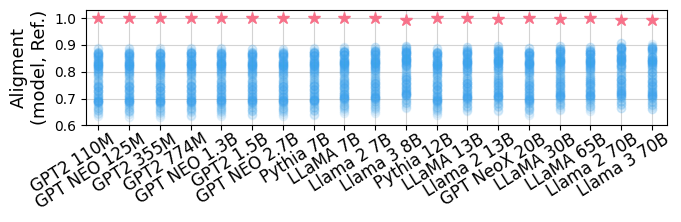

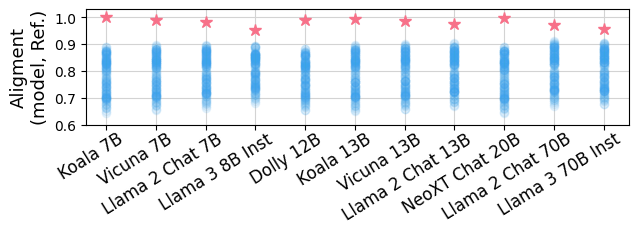

In [12]:
from plot_utils.plot_utils import plot_divergence_subgroups

# not defined here
overall_alignmen = {m: np.nan for m in all_models}

plot_divergence_subgroups(alignment, alignment_model_uniform, overall_alignmen, base_models, model_names, 
                          figsize=(7.5, 1.5))
plt.ylim([0.6, 1.03])
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.savefig('plots/adjusted_kl_subgroups_base_gas.pdf', bbox_inches='tight')


plot_divergence_subgroups(alignment, alignment_model_uniform, overall_alignmen, instruction_models, model_names, 
                          figsize=(7, 1.5))
plt.ylim([0.6, 1.03])
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.savefig('plots/adjusted_kl_subgroups_inst_gas.pdf', bbox_inches='tight')

### Figure 9a

#### With the countries considered by Durmus et al.  at https://llmglobalvalues.anthropic.com/

In [13]:
countries = {
    'United States',
    'Canada',
    'Mexico',
    'Nicaragua',
    'Venezuela',
    'Colombia',
    'Peru',
    'Brazil',
    'Bolivia',
    'Argentina',
    'Chile',
    'Britain',
    'Spain',
    'France',
    'Italy',
    'Belgium',
    'Netherlands',
    'Denmark',
    'Germany',
    'Sweden',
    'Poland',
    'Lithuania',
    'Hungary',
    'Ukraine',
    'Slovakia',
    'Bulgaria',
    'Greece',
    'Russia',
    'Turkey',
    'Morocco',
    'Tunisia',
    'Egypt',
    'Senegal',
    'Mali',
    'Burkina Faso',
    'Ghana',
    'Nigeria',
    'Angola',
    'Uganda',
    'Kenya',
    'Ethiopia',
    'Israel',
    'Jordan',
    'Uzbekistan',
    'Pakistan',
    'China',
    'Bangladesh',
    'Thailand',
    'Vietnam',
    'Indonesia',
    'Malaysia',
    'Taiwan',
    'Japan',
    'Philippines',
    'Australia'
}

In [14]:
subgroup_ent = {c: [] for c in countries}
for v, cs in census_responses.items():
    for c, rc in cs.items():
        if c not in countries:
            continue
        u = np.ones(rc.size) / rc.size
        subgroup_ent[c].append(compute_entropy(rc) / compute_entropy(u))
subgroup_ent = {c: np.mean(subgroup_ent[c]) for c in countries}

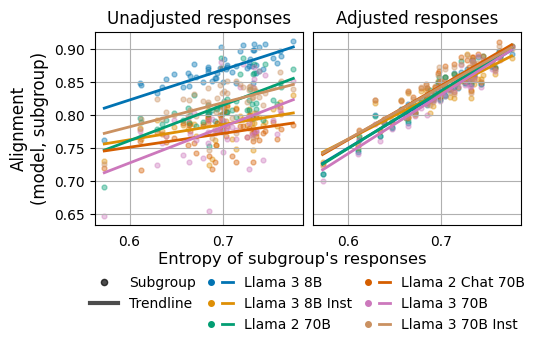

In [15]:
from plot_utils.plot_utils import plot_similarity_opinions

models_of_interest = [
    'llama3-8b',
    'llama3-8b-instruct',
    'llama2-70b',
    'llama2-70b-chat',
    'llama3-70b',
    'llama3-70b-instruct',
]

plot_similarity_opinions(countries, unadj_alignment, alignment,
                         subgroup_ent, models_of_interest, model_names,
                             xlabel='Entropy of subgroup\'s responses', 
                             ylabel='Alignment\n(model, subgroup)',
                             title1='Unadjusted responses', title2='Adjusted responses')

plt.savefig('plots/lin-trend-gas.pdf', bbox_inches='tight')
